# Import

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys, os

# Download Human Faces Dataset

In [ ]:
! pip install kaggle
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [8]:
!mkdir .kaggle

In [9]:
!cp kaggle.json .kaggle

In [17]:
!chmod 600 /root/.kaggle/kaggle.json

In [24]:
ls

human-faces.zip  kaggle.json  sample_data/


In [20]:
!mv human-faces.zip /content/

In [ ]:
!mv .kaggle /root/

In [ ]:
!kaggle datasets list

In [19]:
!kaggle datasets download -d ashwingupta3012/human-faces

100% 1.81G/1.82G [00:11<00:00, 179MB/s]
100% 1.82G/1.82G [00:11<00:00, 176MB/s]


In [ ]:
!unzip human-faces.zip

In [23]:
cd content

/content


# Conver Images To List Of Matrices

In [2]:
import os, cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tqdm

In [3]:
image_names = os.listdir("Humans")
X_train = []
for image_name in tqdm.tqdm(image_names):
  image = cv2.imread(f"Humans/{image_name}", 0)
  image = cv2.resize(image, dsize=(100, 100))
  X_train.append(image)


100%|██████████| 7219/7219 [02:12<00:00, 54.30it/s] 


In [58]:
image.shape

(100, 100)

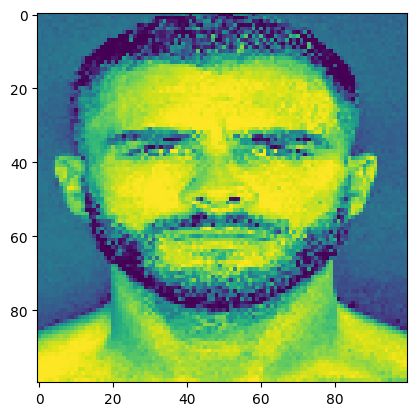

In [59]:
plt.imshow(image)

# Download Numbers Dataset
we can train the model on this or on previous dataset depend on what kind of picture we need to generate


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train/ 255 *2 - 1,  x_test/ 255 *2 - 1


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
y_train[10]

3

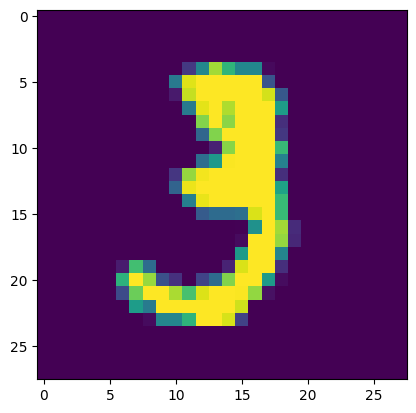

In [4]:
plt.imshow(x_train[10])

# Convert List to numpy array, normalize it around zero

In [4]:
x_train = np.array(X_train)
x_train = x_train/ 255 *2 - 1

In [ ]:
x_train.shape

# Get shape of pictures then flatt them

In [5]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1,D)
# x_test = x_test.reshape(-1, D)

In [28]:
x_train.shape

(60000, 784)

In [6]:
latent_dim = 1000

# Build generator and discriminator layers

In [7]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation = LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(512, activation = LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(1024, activation = LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(D, activation = "tanh")(x)

  model = Model(i, x)
  return model


In [8]:
def build_discriminator(img_size) :
  i = Input(shape=(img_size))
  x = Dense(512, activation = LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation = LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation = "sigmoid")(x)
  model = Model(i, x)
  return model


# Build Combine_model that contains both discriminator and generator

In [20]:
discriminator = build_discriminator(D)
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002,0.5), metrics=["accuracy"])

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim, ))
img = generator(z)

discriminator.trainable = False

fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)

combined_model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))



# Specify some parameters of training and labels(zeros, ones)

In [17]:
batch_size = 128
epochs = 20000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists("gan_images"):
  os.makedirs("gan_images")


# This function Convert flatten matrix(for example 1 * 784) to normal type (for example 28 * 28) then save it

In [18]:
def sample_images(epoch):
  rows, cols = 1, 1
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  axs.imshow(imgs[idx].reshape(H, W), cmap = "gray")
  # for i in range(rows):
  #   for j in range(cols):
  #     axs[i,j].imshow(imgs[idx].reshape(H, W), cmap = "gray")
  #     axs[i,j].axis("off")
  #     idx += 1
  
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()


# Train models through for loop
first train discriminator on real(from dataset) and fake(produced by generator) images then train combined_model.
we pass ones labels to combined_model to trick discriminator and update generator's weights.

each 200 epoch we call sample_imges function to save and see the progress

In [ ]:
for epoch in range(epochs):
  ##### train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

  d_loss = 0.5 * (d_loss_real+d_loss_fake)
  d_acc = 0.5 * (d_acc_real+d_acc_fake)


  ##### TRAIN GENERATOR
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 ==0 :
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \ d_acc/: {d_acc:.2f}, g_loss: {g_loss:.2f} " )

  if epoch % sample_period == 0:
    sample_images(epoch)
  





# I tried on mnist dataset and it's pictures was good.
# I tried on human faces dataset and for 6000 epoch it's results wasn't good enough and then colab crashed. i keep going ... 